# Case Studies: Case Study 3; Accurate continuum limit

This example shows how we obtained the results in the paper
for the third case study, for the case that the continuum limit is
accurate. Let us load in the packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using Random

## Simulating
Let us start by defining the cell problem. We use the force law $F(\ell) = k(s-\ell)$
and the proliferation law $G(\ell) = \beta[1 - 1/(K\ell)]$.

In [2]:
final_time = 50.0
domain_length = 30.0
midpoint = domain_length / 2
initial_condition = [LinRange(0, 5, 30); LinRange(25, 30, 30)] |> unique!
damping_constant = 1.0
resting_spring_length = 0.2
spring_constant = 50.0
k = spring_constant
force_law_parameters = (s=resting_spring_length, k=spring_constant)
force_law = (δ, p) -> p.k * (p.s - δ)
Δt = 1e-2
K = 15.0
β = 0.15
G = (δ, p) -> p.β * (one(δ) - inv(p.K * δ))
Gp = (β=β, K=K)
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant,
    force_law,
    force_law_parameters,
    proliferation_law=G,
    proliferation_period=Δt,
    proliferation_law_parameters=Gp);

Before we solve the problem, we note that the stochastic nature of the proliferation
mechanism implies that the results are not deterministic. To make the results deterministic,
we disable multithreading by providing `EnsembleSerial()`.

In [3]:
ens_prob = EnsembleProblem(prob)
Random.seed!(292919)
esol = solve(ens_prob, Tsit5(), EnsembleSerial(); trajectories=1000, saveat=0.1)

EnsembleSolution Solution of length 1000 with uType:
SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, EpithelialDynamics1D.CellProblem{Main.var"##2278".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##2278".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, EpithelialDynamics1D.CellProblem{Main.var"##2278".var"#1#2", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, Main.var"##2278".var"#3#4", NamedTuple{(:β, :K), Tuple{Float64, Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag

If you do not care about the non-deterministic behaviour and just want a fast result, just do not
provide the third argument.

## Equation learning
We now learn the equations. The basis expansison we use are:

In [4]:
diffusion_basis = PolynomialBasis(-1, -3)
reaction_basis = PolynomialBasis(1, 5)

(::BasisSet{NTuple{5, StepwiseEQL.var"#52#54"{Int64}}}) (generic function with 3 methods)

To learn the equations, we use the call below. We use 50 knots for averaging,
and prune with $\tau_q = 0.1$.

In [5]:
eql_sol = stepwise_selection(esol; diffusion_basis, reaction_basis,
    threshold_tol=(q=0.1,), mesh_points=1000,
    initial=:all, num_knots=50)

StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
    R(q) = θ₁ʳ ϕ₁ʳ(q) + θ₂ʳ ϕ₂ʳ(q)
┌──────┬─────────────────────────┬──────────────────────────────────────────────┬───────┐
│ Step │    θ₁ᵈ     θ₂ᵈ      θ₃ᵈ │  θ₁ʳ    θ₂ʳ        θ₃ʳ        θ₄ʳ        θ₅ʳ │  Loss │
├──────┼─────────────────────────┼──────────────────────────────────────────────┼───────┤
│    1 │ -11.66  147.43  -191.51 │ 0.13  -0.00      -0.00   5.83e-05  -1.13e-06 │   Inf │
│    2 │  -2.24   60.86     0.00 │ 0.13  -0.00  -5.72e-04   2.62e-05  -3.49e-07 │ -0.71 │
│    3 │  -2.25   60.90     0.00 │ 0.14  -0.01       0.00  -1.25e-05   5.95e-07 │ -1.92 │
│    4 │   0.00   52.95     0.00 │ 0.14  -0.01       0.00  -1.36e-05   6.49e-07 │ -3.35 │
│    5 │   0.00   53.02     0.00 │ 0.15  -0.01       0.00       0.00   3.23e-08 │ -4.98 │
│    6 │   0.00   52.97     0.00 │ 0.15  -0.01       0.00       0.00       0.00 │ -5.70 │
└──────┴─────────────────────────┴──────────────────────────────────────────────┴───────┘


## Plotting
We plot the results as follows. To improve the plot visually,
we need to recompute the `AveragedODESolution` so that there are more
knots, since `50` leads to a jagged plot.

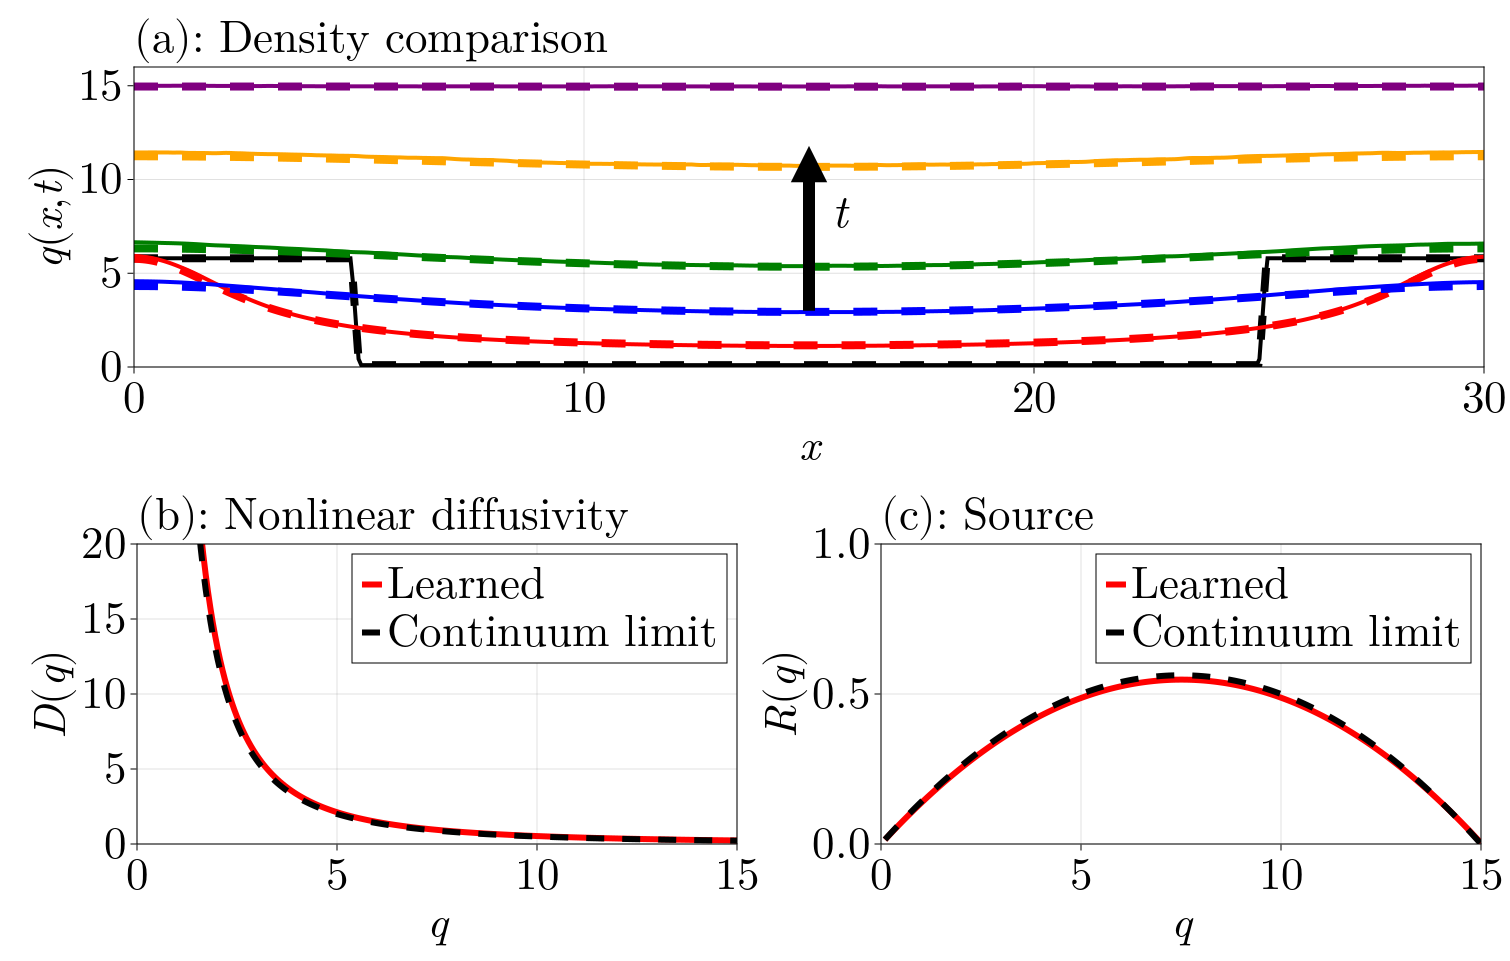

In [6]:
asol = AveragedODESolution(esol, 500) # 500 knots
fig = Figure(fontsize=45, resolution=(1510, 961))
ax = Axis(fig[1, 1:2], xlabel=L"x", ylabel=L"q(x, t)",
    width=1350, height=300,
    title=L"(a):$ $ Density comparison", titlealign=:left,
    xticks=(0:10:30, [L"%$s" for s in 0:10:30]),
    yticks=(0:5:15, [L"%$s" for s in 0:5:15]))
t = (0, 1, 5, 10, 20, 50)
colors = (:black, :red, :blue, :green, :orange, :purple)
time_indices = [findlast(≤(τ), esol[1].t) for τ in t]
for (j, i) in enumerate(time_indices)
    lines!(ax, eql_sol.pde.geometry.mesh_points, eql_sol.pde_sol.u[i], color=colors[j], linestyle=:dash, linewidth=8)
    lines!(ax, asol.u[i], asol.q[i], color=colors[j], linewidth=4)
end
arrows!(ax, [15.0], [3.0], [0.0], [7.5], color=:black, linewidth=12, arrowsize=50)
text!(ax, [15.5], [7.0], text=L"t", color=:black, fontsize=47)
xlims!(ax, 0, 30)
ylims!(ax, 0, 16)
ax2 = Axis(fig[2, 1], xlabel=L"q", ylabel=L"D(q)",
    width=600, height=300,
    title=L"(b):$ $ Nonlinear diffusivity", titlealign=:left,
    xticks=(0:5:15, [L"%$s" for s in 0:5:15]),
    yticks=(0:5:20, [L"%$s" for s in 0:5:20]))
q_range = LinRange(1 / 10, 15, 250)
D_cont_fnc = q -> (force_law_parameters.k / damping_constant) / q^2
R_cont_fnc = q -> β * q * (1 - q / K)
D_sol = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
R_sol = reaction_basis.(q_range, Ref(eql_sol.reaction_theta), Ref(nothing))
D_cont = D_cont_fnc.(q_range)
R_cont = R_cont_fnc.(q_range)
lines!(ax2, q_range, D_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax2, q_range, D_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(position=:rt)
ax3 = Axis(fig[2, 2], xlabel=L"q", ylabel=L"R(q)",
    width=600, height=300,
    title=L"(c):$ $ Source", titlealign=:left,
    xticks=(0:5:15, [L"%$s" for s in 0:5:15]),
    yticks=(0:0.5:1.5, [L"%$s" for s in 0:0.5:1.5]))
lines!(ax3, q_range, R_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax3, q_range, R_cont, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(position=:rt)
ylims!(ax2, 0, 20)
ylims!(ax3, 0, 1)
xlims!(ax2, 0, 15)
xlims!(ax3, 0, 15)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*